In [1]:
pip install vit-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 68 kB 3.5 MB/s 


In [2]:
pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import glob
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import matplotlib.pyplot as plt
from __future__ import print_function
from itertools import chain
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from vit_pytorch.cvt import CvT

In [5]:
# Training settings
batch_size = 64
epochs = 200
lr = 0.00001
gamma = 0.7
seed = 42

In [6]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [7]:
'''
IMAGE CATEGORY ENCODING

Benign = 0
Malignant = 1
'''

'\nIMAGE CATEGORY ENCODING\n\nBenign = 0\nMalignant = 1\n'

In [8]:
from google.colab import drive
drive.mount('/content/drive')

train_list = glob.glob(os.path.join('/content/drive/MyDrive/BreakHis/benign/SOB/adenosis','*.png'))
train_list2 = glob.glob(os.path.join('/content/drive/MyDrive/BreakHis/benign/SOB/fibroadenoma','*.png'))
train_list.extend(train_list2)
train_list2 = glob.glob(os.path.join('/content/drive/MyDrive/BreakHis/benign/SOB/phyllodes_tumor','*.png'))
train_list.extend(train_list2)
train_list2 = glob.glob(os.path.join('/content/drive/MyDrive/BreakHis/benign/SOB/tubular_adenoma','*.png'))
train_list.extend(train_list2)
train_list2 = glob.glob(os.path.join('/content/drive/MyDrive/BreakHis/malignant/SOB/ductal_carcinoma','*.png'))
train_list.extend(train_list2)
train_list2 = glob.glob(os.path.join('/content/drive/MyDrive/BreakHis/malignant/SOB/lobular_carcinoma','*.png'))
train_list.extend(train_list2)
train_list2 = glob.glob(os.path.join('/content/drive/MyDrive/BreakHis/malignant/SOB/mucinous_carcinoma','*.png'))
train_list.extend(train_list2)
train_list2 = glob.glob(os.path.join('/content/drive/MyDrive/BreakHis/malignant/SOB/papillary_carcinoma','*.png'))
train_list.extend(train_list2)

print(f"Train list length: {len(train_list)}")

Mounted at /content/drive
Train list length: 7909


In [9]:
random.shuffle(train_list)

In [10]:
train_list, test_list = train_test_split(train_list,
                                          test_size=0.15,
                                          random_state=42)

In [11]:
test_list, valid_list = train_test_split(test_list,
                                          test_size=0.33,
                                          random_state=42)

In [12]:
print(f"Train Data: {len(train_list)}")
print(f"Valid Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 6722
Valid Data: 392
Test Data: 795


In [13]:
device = 'cuda'

In [14]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=(0, 180)),
        transforms.ColorJitter(brightness=.5, hue=.3),
        transforms.ToTensor(),
    ]
)

valid_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)

In [15]:
class BreakHisDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)

        label = img_path.split("/")[-4].split(".")[0]
        label = 1 if label == "malignant" else 0

        return img_transformed, label

In [16]:
train_data = BreakHisDataset(train_list, transform=train_transforms)
valid_data = BreakHisDataset(valid_list, transform=valid_transforms)
test_data = BreakHisDataset(test_list, transform=test_transforms)

In [17]:
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

In [18]:
model = CvT(
    num_classes = 2,

    s1_emb_dim = 64,        # stage 1 - dimension
    s1_emb_kernel = 7,      # stage 1 - conv kernel
    s1_emb_stride = 4,      # stage 1 - conv stride
    s1_proj_kernel = 3,     # stage 1 - attention ds-conv kernel size
    s1_kv_proj_stride = 2,  # stage 1 - attention key / value projection stride
    s1_heads = 1,           # stage 1 - heads
    s1_depth = 1,           # stage 1 - depth
    s1_mlp_mult = 4,        # stage 1 - feedforward expansion factor

    s2_emb_dim = 192,       # stage 2 - (same as above)
    s2_emb_kernel = 3,
    s2_emb_stride = 2,
    s2_proj_kernel = 3,
    s2_kv_proj_stride = 2,
    s2_heads = 3,
    s2_depth = 2,
    s2_mlp_mult = 4,

    s3_emb_dim = 384,       # stage 3 - (same as above)
    s3_emb_kernel = 3,
    s3_emb_stride = 2,
    s3_proj_kernel = 3,
    s3_kv_proj_stride = 2,
    s3_heads = 4,
    s3_depth = 10,
    s3_mlp_mult = 4,

    dropout = 0.1
).to(device)

In [19]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [20]:
train_loss_list = []
train_accuracy_list = []
val_loss_list = []
val_accuracy_list = []

bestloss = 100
patience = 15
triggers = 0

In [21]:
start_time = time.time()

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    model.train()
    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)
        
        optimizer.zero_grad()

        output = model(data)
        loss = criterion(output, label)

        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss.item() / len(train_loader)

    model.eval()
    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss.item() / len(valid_loader)
    
    train_loss_list.append(epoch_loss)
    train_accuracy_list.append(epoch_accuracy)
    val_loss_list.append(epoch_val_loss)
    val_accuracy_list.append(epoch_val_accuracy)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

    if(epoch_loss < bestloss):
        triggers = 0
        bestloss = epoch_loss
        torch.save(model.state_dict(), "/content/drive/MyDrive/SavedViTModels/CvTSavedModel2.pth")
        torch.save(optimizer.state_dict(), "/content/drive/MyDrive/SavedViTModels/CvTSavedOptimizer2.pth")
    else:
        triggers += 1

    if triggers == patience:
        print("Early stopping since epoch_loss > bestloss for 15 epochs")
        break

end_time = time.time()

print(f"\nTime taken to train the model: {(end_time - start_time)/60/60} hours")

100%|██████████| 106/106 [30:21<00:00, 17.19s/it]


Epoch : 1 - loss : 0.5362 - acc: 0.7423 - val_loss : 0.4641 - val_acc: 0.8371



100%|██████████| 106/106 [03:41<00:00,  2.09s/it]


Epoch : 2 - loss : 0.4927 - acc: 0.7838 - val_loss : 0.5248 - val_acc: 0.8326



100%|██████████| 106/106 [03:40<00:00,  2.08s/it]


Epoch : 3 - loss : 0.4853 - acc: 0.7855 - val_loss : 0.5046 - val_acc: 0.8103



100%|██████████| 106/106 [03:38<00:00,  2.06s/it]


Epoch : 4 - loss : 0.4888 - acc: 0.7841 - val_loss : 0.4762 - val_acc: 0.7991



100%|██████████| 106/106 [03:37<00:00,  2.05s/it]


Epoch : 5 - loss : 0.4851 - acc: 0.7879 - val_loss : 0.4378 - val_acc: 0.8438



100%|██████████| 106/106 [03:38<00:00,  2.06s/it]


Epoch : 6 - loss : 0.4798 - acc: 0.7899 - val_loss : 0.4618 - val_acc: 0.8259



100%|██████████| 106/106 [03:37<00:00,  2.05s/it]


Epoch : 7 - loss : 0.4837 - acc: 0.7899 - val_loss : 0.4139 - val_acc: 0.8415



100%|██████████| 106/106 [03:37<00:00,  2.05s/it]


Epoch : 8 - loss : 0.4744 - acc: 0.7951 - val_loss : 0.4462 - val_acc: 0.7991



100%|██████████| 106/106 [03:38<00:00,  2.06s/it]


Epoch : 9 - loss : 0.4772 - acc: 0.7867 - val_loss : 0.4215 - val_acc: 0.8326



100%|██████████| 106/106 [03:37<00:00,  2.05s/it]


Epoch : 10 - loss : 0.4805 - acc: 0.7944 - val_loss : 0.4668 - val_acc: 0.8058



100%|██████████| 106/106 [03:37<00:00,  2.05s/it]


Epoch : 11 - loss : 0.4813 - acc: 0.7905 - val_loss : 0.4273 - val_acc: 0.8259



100%|██████████| 106/106 [03:38<00:00,  2.06s/it]


Epoch : 12 - loss : 0.4763 - acc: 0.7935 - val_loss : 0.5651 - val_acc: 0.7612



100%|██████████| 106/106 [03:39<00:00,  2.07s/it]


Epoch : 13 - loss : 0.4761 - acc: 0.7942 - val_loss : 0.3875 - val_acc: 0.8616



100%|██████████| 106/106 [03:38<00:00,  2.06s/it]


Epoch : 14 - loss : 0.4732 - acc: 0.7929 - val_loss : 0.5179 - val_acc: 0.7835



100%|██████████| 106/106 [03:39<00:00,  2.07s/it]


Epoch : 15 - loss : 0.4737 - acc: 0.8003 - val_loss : 0.4371 - val_acc: 0.8304



100%|██████████| 106/106 [03:38<00:00,  2.06s/it]


Epoch : 16 - loss : 0.4751 - acc: 0.7979 - val_loss : 0.4895 - val_acc: 0.7701



100%|██████████| 106/106 [03:38<00:00,  2.06s/it]


Epoch : 17 - loss : 0.4746 - acc: 0.7969 - val_loss : 0.5300 - val_acc: 0.7924



100%|██████████| 106/106 [03:38<00:00,  2.06s/it]


Epoch : 18 - loss : 0.4694 - acc: 0.7989 - val_loss : 0.5596 - val_acc: 0.7835



100%|██████████| 106/106 [03:39<00:00,  2.07s/it]


Epoch : 19 - loss : 0.4659 - acc: 0.7994 - val_loss : 0.4145 - val_acc: 0.8438



100%|██████████| 106/106 [03:39<00:00,  2.07s/it]


Epoch : 20 - loss : 0.4681 - acc: 0.7944 - val_loss : 0.4913 - val_acc: 0.8281



100%|██████████| 106/106 [03:37<00:00,  2.06s/it]


Epoch : 21 - loss : 0.4691 - acc: 0.8014 - val_loss : 0.3801 - val_acc: 0.8549



100%|██████████| 106/106 [03:38<00:00,  2.06s/it]


Epoch : 22 - loss : 0.4679 - acc: 0.8013 - val_loss : 0.4649 - val_acc: 0.8125



100%|██████████| 106/106 [03:37<00:00,  2.05s/it]


Epoch : 23 - loss : 0.4656 - acc: 0.8016 - val_loss : 0.4156 - val_acc: 0.8460



100%|██████████| 106/106 [03:37<00:00,  2.05s/it]


Epoch : 24 - loss : 0.4691 - acc: 0.7951 - val_loss : 0.4626 - val_acc: 0.8013



100%|██████████| 106/106 [03:37<00:00,  2.05s/it]


Epoch : 25 - loss : 0.4628 - acc: 0.8034 - val_loss : 0.4176 - val_acc: 0.8371



100%|██████████| 106/106 [03:38<00:00,  2.06s/it]


Epoch : 26 - loss : 0.4629 - acc: 0.8016 - val_loss : 0.3750 - val_acc: 0.8661



100%|██████████| 106/106 [03:38<00:00,  2.06s/it]


Epoch : 27 - loss : 0.4655 - acc: 0.7989 - val_loss : 0.4473 - val_acc: 0.8103



100%|██████████| 106/106 [03:38<00:00,  2.06s/it]


Epoch : 28 - loss : 0.4613 - acc: 0.7997 - val_loss : 0.5044 - val_acc: 0.7522



100%|██████████| 106/106 [03:39<00:00,  2.07s/it]


Epoch : 29 - loss : 0.4785 - acc: 0.7950 - val_loss : 0.3726 - val_acc: 0.8638



100%|██████████| 106/106 [03:36<00:00,  2.05s/it]


Epoch : 30 - loss : 0.4698 - acc: 0.7995 - val_loss : 0.4026 - val_acc: 0.8594



100%|██████████| 106/106 [03:37<00:00,  2.05s/it]


Epoch : 31 - loss : 0.4639 - acc: 0.7988 - val_loss : 0.4368 - val_acc: 0.8304



100%|██████████| 106/106 [03:37<00:00,  2.05s/it]


Epoch : 32 - loss : 0.4538 - acc: 0.8081 - val_loss : 0.5179 - val_acc: 0.7679



100%|██████████| 106/106 [03:37<00:00,  2.06s/it]


Epoch : 33 - loss : 0.4657 - acc: 0.7970 - val_loss : 0.4971 - val_acc: 0.7433



100%|██████████| 106/106 [03:36<00:00,  2.04s/it]


Epoch : 34 - loss : 0.4727 - acc: 0.7895 - val_loss : 0.5865 - val_acc: 0.6964



100%|██████████| 106/106 [03:36<00:00,  2.05s/it]


Epoch : 35 - loss : 0.4594 - acc: 0.8003 - val_loss : 0.4491 - val_acc: 0.7946



100%|██████████| 106/106 [03:37<00:00,  2.05s/it]


Epoch : 36 - loss : 0.4598 - acc: 0.8078 - val_loss : 0.5550 - val_acc: 0.7411



100%|██████████| 106/106 [03:36<00:00,  2.05s/it]


Epoch : 37 - loss : 0.4520 - acc: 0.8045 - val_loss : 0.4985 - val_acc: 0.7969



100%|██████████| 106/106 [03:40<00:00,  2.08s/it]


Epoch : 38 - loss : 0.4625 - acc: 0.8023 - val_loss : 0.4384 - val_acc: 0.8438



100%|██████████| 106/106 [03:37<00:00,  2.05s/it]


Epoch : 39 - loss : 0.4577 - acc: 0.8050 - val_loss : 0.4642 - val_acc: 0.7857



100%|██████████| 106/106 [03:37<00:00,  2.05s/it]


Epoch : 40 - loss : 0.4480 - acc: 0.8113 - val_loss : 0.4316 - val_acc: 0.8438



100%|██████████| 106/106 [03:42<00:00,  2.10s/it]


Epoch : 41 - loss : 0.4541 - acc: 0.8045 - val_loss : 0.4741 - val_acc: 0.8058



100%|██████████| 106/106 [03:40<00:00,  2.08s/it]


Epoch : 42 - loss : 0.4678 - acc: 0.8041 - val_loss : 0.5357 - val_acc: 0.8125



100%|██████████| 106/106 [03:42<00:00,  2.10s/it]


Epoch : 43 - loss : 0.4523 - acc: 0.8087 - val_loss : 0.4627 - val_acc: 0.8036



100%|██████████| 106/106 [03:46<00:00,  2.14s/it]


Epoch : 44 - loss : 0.4576 - acc: 0.8041 - val_loss : 0.4578 - val_acc: 0.8348



100%|██████████| 106/106 [03:50<00:00,  2.17s/it]


Epoch : 45 - loss : 0.4491 - acc: 0.8063 - val_loss : 0.3900 - val_acc: 0.8460



100%|██████████| 106/106 [03:48<00:00,  2.16s/it]


Epoch : 46 - loss : 0.4547 - acc: 0.8042 - val_loss : 0.4562 - val_acc: 0.8058



100%|██████████| 106/106 [03:37<00:00,  2.05s/it]


Epoch : 47 - loss : 0.4607 - acc: 0.8050 - val_loss : 0.4323 - val_acc: 0.8438



100%|██████████| 106/106 [03:48<00:00,  2.15s/it]


Epoch : 48 - loss : 0.4553 - acc: 0.8107 - val_loss : 0.4691 - val_acc: 0.8393



100%|██████████| 106/106 [03:46<00:00,  2.14s/it]


Epoch : 49 - loss : 0.4515 - acc: 0.8072 - val_loss : 0.3786 - val_acc: 0.8527



100%|██████████| 106/106 [03:49<00:00,  2.17s/it]


Epoch : 50 - loss : 0.4578 - acc: 0.8035 - val_loss : 0.3762 - val_acc: 0.8571



100%|██████████| 106/106 [03:49<00:00,  2.17s/it]


Epoch : 51 - loss : 0.4490 - acc: 0.8100 - val_loss : 0.3702 - val_acc: 0.8549



100%|██████████| 106/106 [03:48<00:00,  2.16s/it]


Epoch : 52 - loss : 0.4458 - acc: 0.8131 - val_loss : 0.3799 - val_acc: 0.8504



100%|██████████| 106/106 [03:36<00:00,  2.05s/it]


Epoch : 53 - loss : 0.4529 - acc: 0.8070 - val_loss : 0.3758 - val_acc: 0.8594



100%|██████████| 106/106 [03:36<00:00,  2.04s/it]


Epoch : 54 - loss : 0.4505 - acc: 0.8032 - val_loss : 0.6452 - val_acc: 0.7277



100%|██████████| 106/106 [03:35<00:00,  2.03s/it]


Epoch : 55 - loss : 0.4534 - acc: 0.8041 - val_loss : 0.4796 - val_acc: 0.8125



100%|██████████| 106/106 [03:36<00:00,  2.04s/it]


Epoch : 56 - loss : 0.4540 - acc: 0.8107 - val_loss : 0.4488 - val_acc: 0.8036



100%|██████████| 106/106 [03:37<00:00,  2.05s/it]


Epoch : 57 - loss : 0.4511 - acc: 0.8056 - val_loss : 0.4409 - val_acc: 0.8125



100%|██████████| 106/106 [03:37<00:00,  2.05s/it]


Epoch : 58 - loss : 0.4428 - acc: 0.8168 - val_loss : 0.3710 - val_acc: 0.8616



100%|██████████| 106/106 [03:37<00:00,  2.05s/it]


Epoch : 59 - loss : 0.4457 - acc: 0.8109 - val_loss : 0.4092 - val_acc: 0.8281



100%|██████████| 106/106 [03:36<00:00,  2.05s/it]


Epoch : 60 - loss : 0.4483 - acc: 0.8090 - val_loss : 0.5006 - val_acc: 0.7812



100%|██████████| 106/106 [03:37<00:00,  2.06s/it]


Epoch : 61 - loss : 0.4478 - acc: 0.8134 - val_loss : 0.3952 - val_acc: 0.8504



100%|██████████| 106/106 [03:36<00:00,  2.04s/it]


Epoch : 62 - loss : 0.4489 - acc: 0.8082 - val_loss : 0.4107 - val_acc: 0.8415



100%|██████████| 106/106 [03:36<00:00,  2.04s/it]


Epoch : 63 - loss : 0.4411 - acc: 0.8137 - val_loss : 0.4512 - val_acc: 0.8103



100%|██████████| 106/106 [03:37<00:00,  2.05s/it]


Epoch : 64 - loss : 0.4399 - acc: 0.8174 - val_loss : 0.4323 - val_acc: 0.8103



100%|██████████| 106/106 [03:37<00:00,  2.05s/it]


Epoch : 65 - loss : 0.4391 - acc: 0.8169 - val_loss : 0.3812 - val_acc: 0.8504



100%|██████████| 106/106 [03:37<00:00,  2.05s/it]


Epoch : 66 - loss : 0.4476 - acc: 0.8150 - val_loss : 0.3850 - val_acc: 0.8438



100%|██████████| 106/106 [03:37<00:00,  2.05s/it]


Epoch : 67 - loss : 0.4398 - acc: 0.8152 - val_loss : 0.4517 - val_acc: 0.8237



100%|██████████| 106/106 [03:37<00:00,  2.05s/it]


Epoch : 68 - loss : 0.4444 - acc: 0.8141 - val_loss : 0.3675 - val_acc: 0.8638



100%|██████████| 106/106 [03:37<00:00,  2.05s/it]


Epoch : 69 - loss : 0.4408 - acc: 0.8141 - val_loss : 0.4262 - val_acc: 0.8438



100%|██████████| 106/106 [03:37<00:00,  2.05s/it]


Epoch : 70 - loss : 0.4422 - acc: 0.8126 - val_loss : 0.3960 - val_acc: 0.8549



100%|██████████| 106/106 [03:36<00:00,  2.05s/it]


Epoch : 71 - loss : 0.4460 - acc: 0.8113 - val_loss : 0.4228 - val_acc: 0.8237



100%|██████████| 106/106 [03:36<00:00,  2.04s/it]


Epoch : 72 - loss : 0.4344 - acc: 0.8206 - val_loss : 0.4219 - val_acc: 0.8482



100%|██████████| 106/106 [03:37<00:00,  2.05s/it]


Epoch : 73 - loss : 0.4403 - acc: 0.8141 - val_loss : 0.4914 - val_acc: 0.8058



100%|██████████| 106/106 [03:37<00:00,  2.05s/it]


Epoch : 74 - loss : 0.4332 - acc: 0.8188 - val_loss : 0.4282 - val_acc: 0.8259



100%|██████████| 106/106 [03:39<00:00,  2.07s/it]


Epoch : 75 - loss : 0.4436 - acc: 0.8063 - val_loss : 0.4588 - val_acc: 0.7991



100%|██████████| 106/106 [03:37<00:00,  2.06s/it]


Epoch : 76 - loss : 0.4373 - acc: 0.8196 - val_loss : 0.4498 - val_acc: 0.8259



100%|██████████| 106/106 [03:39<00:00,  2.07s/it]


Epoch : 77 - loss : 0.4426 - acc: 0.8137 - val_loss : 0.3845 - val_acc: 0.8504



100%|██████████| 106/106 [03:44<00:00,  2.12s/it]


Epoch : 78 - loss : 0.4324 - acc: 0.8228 - val_loss : 0.4486 - val_acc: 0.8460



100%|██████████| 106/106 [03:37<00:00,  2.05s/it]


Epoch : 79 - loss : 0.4359 - acc: 0.8180 - val_loss : 0.4327 - val_acc: 0.8259



100%|██████████| 106/106 [03:38<00:00,  2.06s/it]


Epoch : 80 - loss : 0.4374 - acc: 0.8185 - val_loss : 0.4221 - val_acc: 0.8438



100%|██████████| 106/106 [03:43<00:00,  2.11s/it]


Epoch : 81 - loss : 0.4354 - acc: 0.8187 - val_loss : 0.3808 - val_acc: 0.8504



100%|██████████| 106/106 [03:43<00:00,  2.11s/it]


Epoch : 82 - loss : 0.4317 - acc: 0.8172 - val_loss : 0.4196 - val_acc: 0.8170



100%|██████████| 106/106 [03:42<00:00,  2.10s/it]


Epoch : 83 - loss : 0.4319 - acc: 0.8166 - val_loss : 0.3843 - val_acc: 0.8438



100%|██████████| 106/106 [03:40<00:00,  2.08s/it]


Epoch : 84 - loss : 0.4330 - acc: 0.8194 - val_loss : 0.4136 - val_acc: 0.8170



100%|██████████| 106/106 [03:41<00:00,  2.09s/it]


Epoch : 85 - loss : 0.4387 - acc: 0.8166 - val_loss : 0.4279 - val_acc: 0.8326



100%|██████████| 106/106 [03:40<00:00,  2.08s/it]


Epoch : 86 - loss : 0.4432 - acc: 0.8178 - val_loss : 0.3559 - val_acc: 0.8683



100%|██████████| 106/106 [03:40<00:00,  2.08s/it]


Epoch : 87 - loss : 0.4440 - acc: 0.8180 - val_loss : 0.3978 - val_acc: 0.8415



100%|██████████| 106/106 [03:38<00:00,  2.06s/it]


Epoch : 88 - loss : 0.4373 - acc: 0.8156 - val_loss : 0.3584 - val_acc: 0.8638



100%|██████████| 106/106 [03:37<00:00,  2.05s/it]


Epoch : 89 - loss : 0.4322 - acc: 0.8171 - val_loss : 0.3999 - val_acc: 0.8348



100%|██████████| 106/106 [03:39<00:00,  2.07s/it]


Epoch : 90 - loss : 0.4349 - acc: 0.8199 - val_loss : 0.3948 - val_acc: 0.8460



100%|██████████| 106/106 [03:39<00:00,  2.07s/it]


Epoch : 91 - loss : 0.4458 - acc: 0.8121 - val_loss : 0.3846 - val_acc: 0.8549



100%|██████████| 106/106 [03:38<00:00,  2.07s/it]


Epoch : 92 - loss : 0.4282 - acc: 0.8216 - val_loss : 0.4253 - val_acc: 0.8438



100%|██████████| 106/106 [03:40<00:00,  2.08s/it]


Epoch : 93 - loss : 0.4221 - acc: 0.8233 - val_loss : 0.3964 - val_acc: 0.8371



100%|██████████| 106/106 [03:39<00:00,  2.07s/it]


Epoch : 94 - loss : 0.4174 - acc: 0.8262 - val_loss : 0.4278 - val_acc: 0.8192



100%|██████████| 106/106 [03:39<00:00,  2.08s/it]


Epoch : 95 - loss : 0.4260 - acc: 0.8224 - val_loss : 0.3597 - val_acc: 0.8683



100%|██████████| 106/106 [03:39<00:00,  2.07s/it]


Epoch : 96 - loss : 0.4426 - acc: 0.8180 - val_loss : 0.3374 - val_acc: 0.8772



100%|██████████| 106/106 [03:38<00:00,  2.07s/it]


Epoch : 97 - loss : 0.4257 - acc: 0.8261 - val_loss : 0.3674 - val_acc: 0.8638



100%|██████████| 106/106 [03:40<00:00,  2.08s/it]


Epoch : 98 - loss : 0.4280 - acc: 0.8231 - val_loss : 0.3978 - val_acc: 0.8170



100%|██████████| 106/106 [03:39<00:00,  2.07s/it]


Epoch : 99 - loss : 0.4228 - acc: 0.8187 - val_loss : 0.3260 - val_acc: 0.8795



100%|██████████| 106/106 [03:39<00:00,  2.07s/it]


Epoch : 100 - loss : 0.4167 - acc: 0.8271 - val_loss : 0.3382 - val_acc: 0.8661



100%|██████████| 106/106 [03:40<00:00,  2.08s/it]


Epoch : 101 - loss : 0.4115 - acc: 0.8312 - val_loss : 0.3565 - val_acc: 0.8527



100%|██████████| 106/106 [03:37<00:00,  2.05s/it]


Epoch : 102 - loss : 0.4193 - acc: 0.8224 - val_loss : 0.4086 - val_acc: 0.8304



100%|██████████| 106/106 [03:39<00:00,  2.07s/it]


Epoch : 103 - loss : 0.4108 - acc: 0.8314 - val_loss : 0.3835 - val_acc: 0.8504



100%|██████████| 106/106 [03:38<00:00,  2.06s/it]


Epoch : 104 - loss : 0.4139 - acc: 0.8311 - val_loss : 0.3638 - val_acc: 0.8616



100%|██████████| 106/106 [03:38<00:00,  2.06s/it]


Epoch : 105 - loss : 0.4085 - acc: 0.8340 - val_loss : 0.3241 - val_acc: 0.8772



100%|██████████| 106/106 [03:39<00:00,  2.07s/it]


Epoch : 106 - loss : 0.4111 - acc: 0.8277 - val_loss : 0.3147 - val_acc: 0.8839



100%|██████████| 106/106 [03:38<00:00,  2.06s/it]


Epoch : 107 - loss : 0.4227 - acc: 0.8219 - val_loss : 0.3322 - val_acc: 0.8683



100%|██████████| 106/106 [03:37<00:00,  2.05s/it]


Epoch : 108 - loss : 0.4111 - acc: 0.8339 - val_loss : 0.3999 - val_acc: 0.8192



100%|██████████| 106/106 [03:38<00:00,  2.06s/it]


Epoch : 109 - loss : 0.4102 - acc: 0.8315 - val_loss : 0.3856 - val_acc: 0.8348



100%|██████████| 106/106 [03:38<00:00,  2.06s/it]


Epoch : 110 - loss : 0.4023 - acc: 0.8339 - val_loss : 0.3524 - val_acc: 0.8549



100%|██████████| 106/106 [03:39<00:00,  2.07s/it]


Epoch : 111 - loss : 0.4027 - acc: 0.8333 - val_loss : 0.3652 - val_acc: 0.8460



100%|██████████| 106/106 [03:40<00:00,  2.08s/it]


Epoch : 112 - loss : 0.3965 - acc: 0.8339 - val_loss : 0.3182 - val_acc: 0.8661



100%|██████████| 106/106 [03:38<00:00,  2.06s/it]


Epoch : 113 - loss : 0.4082 - acc: 0.8311 - val_loss : 0.3208 - val_acc: 0.8705



100%|██████████| 106/106 [03:38<00:00,  2.06s/it]


Epoch : 114 - loss : 0.4024 - acc: 0.8320 - val_loss : 0.4580 - val_acc: 0.8281



100%|██████████| 106/106 [03:42<00:00,  2.10s/it]


Epoch : 115 - loss : 0.4014 - acc: 0.8345 - val_loss : 0.3174 - val_acc: 0.8482



100%|██████████| 106/106 [03:42<00:00,  2.10s/it]


Epoch : 116 - loss : 0.3902 - acc: 0.8418 - val_loss : 0.3583 - val_acc: 0.8527



100%|██████████| 106/106 [03:41<00:00,  2.09s/it]


Epoch : 117 - loss : 0.3981 - acc: 0.8333 - val_loss : 0.3817 - val_acc: 0.8192



100%|██████████| 106/106 [03:40<00:00,  2.08s/it]


Epoch : 118 - loss : 0.3973 - acc: 0.8320 - val_loss : 0.3045 - val_acc: 0.8862



100%|██████████| 106/106 [03:41<00:00,  2.09s/it]


Epoch : 119 - loss : 0.3987 - acc: 0.8293 - val_loss : 0.2880 - val_acc: 0.8906



100%|██████████| 106/106 [03:42<00:00,  2.10s/it]


Epoch : 120 - loss : 0.3989 - acc: 0.8320 - val_loss : 0.3944 - val_acc: 0.8348



100%|██████████| 106/106 [03:41<00:00,  2.09s/it]


Epoch : 121 - loss : 0.3930 - acc: 0.8379 - val_loss : 0.3213 - val_acc: 0.8683



100%|██████████| 106/106 [03:40<00:00,  2.08s/it]


Epoch : 122 - loss : 0.3880 - acc: 0.8435 - val_loss : 0.4029 - val_acc: 0.8393



100%|██████████| 106/106 [03:41<00:00,  2.09s/it]


Epoch : 123 - loss : 0.3948 - acc: 0.8323 - val_loss : 0.3365 - val_acc: 0.8772



100%|██████████| 106/106 [03:41<00:00,  2.09s/it]


Epoch : 124 - loss : 0.3935 - acc: 0.8353 - val_loss : 0.2619 - val_acc: 0.9063



100%|██████████| 106/106 [03:40<00:00,  2.08s/it]


Epoch : 125 - loss : 0.3836 - acc: 0.8420 - val_loss : 0.2803 - val_acc: 0.8884



100%|██████████| 106/106 [03:40<00:00,  2.08s/it]


Epoch : 126 - loss : 0.3870 - acc: 0.8389 - val_loss : 0.3403 - val_acc: 0.8482



100%|██████████| 106/106 [03:40<00:00,  2.08s/it]


Epoch : 127 - loss : 0.3790 - acc: 0.8445 - val_loss : 0.2788 - val_acc: 0.8862



100%|██████████| 106/106 [03:40<00:00,  2.08s/it]


Epoch : 128 - loss : 0.3809 - acc: 0.8432 - val_loss : 0.2981 - val_acc: 0.8728



100%|██████████| 106/106 [03:35<00:00,  2.03s/it]


Epoch : 129 - loss : 0.3793 - acc: 0.8404 - val_loss : 0.3448 - val_acc: 0.8594



100%|██████████| 106/106 [03:34<00:00,  2.03s/it]


Epoch : 130 - loss : 0.3789 - acc: 0.8445 - val_loss : 0.3099 - val_acc: 0.8705



100%|██████████| 106/106 [03:35<00:00,  2.04s/it]


Epoch : 131 - loss : 0.3806 - acc: 0.8393 - val_loss : 0.2928 - val_acc: 0.8571



100%|██████████| 106/106 [03:35<00:00,  2.03s/it]


Epoch : 132 - loss : 0.3734 - acc: 0.8486 - val_loss : 0.2981 - val_acc: 0.8884



100%|██████████| 106/106 [03:37<00:00,  2.05s/it]


Epoch : 133 - loss : 0.3719 - acc: 0.8504 - val_loss : 0.3195 - val_acc: 0.8705



100%|██████████| 106/106 [03:37<00:00,  2.05s/it]


Epoch : 134 - loss : 0.3773 - acc: 0.8418 - val_loss : 0.2663 - val_acc: 0.8906



100%|██████████| 106/106 [03:37<00:00,  2.05s/it]


Epoch : 135 - loss : 0.3684 - acc: 0.8480 - val_loss : 0.3113 - val_acc: 0.8616



100%|██████████| 106/106 [03:38<00:00,  2.06s/it]


Epoch : 136 - loss : 0.3704 - acc: 0.8442 - val_loss : 0.2881 - val_acc: 0.8772



100%|██████████| 106/106 [03:37<00:00,  2.05s/it]


Epoch : 137 - loss : 0.3798 - acc: 0.8415 - val_loss : 0.3071 - val_acc: 0.8884



100%|██████████| 106/106 [03:38<00:00,  2.06s/it]


Epoch : 138 - loss : 0.3914 - acc: 0.8355 - val_loss : 0.2849 - val_acc: 0.8795



100%|██████████| 106/106 [03:38<00:00,  2.06s/it]


Epoch : 139 - loss : 0.3776 - acc: 0.8436 - val_loss : 0.2617 - val_acc: 0.8884



100%|██████████| 106/106 [03:37<00:00,  2.05s/it]


Epoch : 140 - loss : 0.3673 - acc: 0.8502 - val_loss : 0.2940 - val_acc: 0.9152



100%|██████████| 106/106 [03:39<00:00,  2.07s/it]


Epoch : 141 - loss : 0.3689 - acc: 0.8449 - val_loss : 0.3338 - val_acc: 0.8616



100%|██████████| 106/106 [03:38<00:00,  2.06s/it]


Epoch : 142 - loss : 0.3740 - acc: 0.8482 - val_loss : 0.3002 - val_acc: 0.8683



100%|██████████| 106/106 [03:37<00:00,  2.05s/it]


Epoch : 143 - loss : 0.3685 - acc: 0.8463 - val_loss : 0.3222 - val_acc: 0.8705



100%|██████████| 106/106 [03:37<00:00,  2.05s/it]


Epoch : 144 - loss : 0.3753 - acc: 0.8476 - val_loss : 0.2768 - val_acc: 0.9018



100%|██████████| 106/106 [03:37<00:00,  2.06s/it]


Epoch : 145 - loss : 0.3765 - acc: 0.8455 - val_loss : 0.3455 - val_acc: 0.8482



100%|██████████| 106/106 [03:37<00:00,  2.06s/it]


Epoch : 146 - loss : 0.3647 - acc: 0.8513 - val_loss : 0.2839 - val_acc: 0.8862



100%|██████████| 106/106 [03:38<00:00,  2.06s/it]


Epoch : 147 - loss : 0.3679 - acc: 0.8464 - val_loss : 0.3535 - val_acc: 0.8527



100%|██████████| 106/106 [03:37<00:00,  2.06s/it]


Epoch : 148 - loss : 0.3651 - acc: 0.8499 - val_loss : 0.2646 - val_acc: 0.9063



100%|██████████| 106/106 [03:37<00:00,  2.06s/it]


Epoch : 149 - loss : 0.3653 - acc: 0.8508 - val_loss : 0.2690 - val_acc: 0.8951



100%|██████████| 106/106 [03:39<00:00,  2.07s/it]


Epoch : 150 - loss : 0.3693 - acc: 0.8454 - val_loss : 0.2729 - val_acc: 0.8929



100%|██████████| 106/106 [03:39<00:00,  2.07s/it]


Epoch : 151 - loss : 0.3712 - acc: 0.8452 - val_loss : 0.2720 - val_acc: 0.8839



100%|██████████| 106/106 [03:38<00:00,  2.06s/it]


Epoch : 152 - loss : 0.3710 - acc: 0.8508 - val_loss : 0.3270 - val_acc: 0.8772



100%|██████████| 106/106 [03:38<00:00,  2.06s/it]


Epoch : 153 - loss : 0.3734 - acc: 0.8498 - val_loss : 0.3351 - val_acc: 0.8817



100%|██████████| 106/106 [03:38<00:00,  2.06s/it]


Epoch : 154 - loss : 0.3570 - acc: 0.8567 - val_loss : 0.3062 - val_acc: 0.8616



100%|██████████| 106/106 [03:38<00:00,  2.06s/it]


Epoch : 155 - loss : 0.3652 - acc: 0.8507 - val_loss : 0.2447 - val_acc: 0.8951



100%|██████████| 106/106 [03:38<00:00,  2.06s/it]


Epoch : 156 - loss : 0.3612 - acc: 0.8523 - val_loss : 0.2913 - val_acc: 0.8817



100%|██████████| 106/106 [03:38<00:00,  2.06s/it]


Epoch : 157 - loss : 0.3587 - acc: 0.8527 - val_loss : 0.2980 - val_acc: 0.8884



100%|██████████| 106/106 [03:38<00:00,  2.06s/it]


Epoch : 158 - loss : 0.3510 - acc: 0.8583 - val_loss : 0.2639 - val_acc: 0.8862



100%|██████████| 106/106 [03:39<00:00,  2.07s/it]


Epoch : 159 - loss : 0.3715 - acc: 0.8476 - val_loss : 0.2714 - val_acc: 0.8884



100%|██████████| 106/106 [03:39<00:00,  2.07s/it]


Epoch : 160 - loss : 0.3606 - acc: 0.8504 - val_loss : 0.2508 - val_acc: 0.9085



100%|██████████| 106/106 [03:40<00:00,  2.08s/it]


Epoch : 161 - loss : 0.3585 - acc: 0.8544 - val_loss : 0.2373 - val_acc: 0.8862



100%|██████████| 106/106 [03:37<00:00,  2.05s/it]


Epoch : 162 - loss : 0.3596 - acc: 0.8533 - val_loss : 0.2541 - val_acc: 0.9062



100%|██████████| 106/106 [03:37<00:00,  2.05s/it]


Epoch : 163 - loss : 0.3581 - acc: 0.8520 - val_loss : 0.2365 - val_acc: 0.9107



100%|██████████| 106/106 [03:37<00:00,  2.05s/it]


Epoch : 164 - loss : 0.3559 - acc: 0.8516 - val_loss : 0.2743 - val_acc: 0.8839



100%|██████████| 106/106 [03:38<00:00,  2.06s/it]


Epoch : 165 - loss : 0.3516 - acc: 0.8598 - val_loss : 0.3011 - val_acc: 0.8817



100%|██████████| 106/106 [03:39<00:00,  2.07s/it]


Epoch : 166 - loss : 0.3543 - acc: 0.8563 - val_loss : 0.2955 - val_acc: 0.8951



100%|██████████| 106/106 [03:39<00:00,  2.07s/it]


Epoch : 167 - loss : 0.3531 - acc: 0.8536 - val_loss : 0.3011 - val_acc: 0.8795



100%|██████████| 106/106 [03:40<00:00,  2.08s/it]


Epoch : 168 - loss : 0.3530 - acc: 0.8573 - val_loss : 0.2672 - val_acc: 0.8728



100%|██████████| 106/106 [03:38<00:00,  2.06s/it]


Epoch : 169 - loss : 0.3712 - acc: 0.8377 - val_loss : 0.2561 - val_acc: 0.9129



100%|██████████| 106/106 [03:37<00:00,  2.05s/it]


Epoch : 170 - loss : 0.3621 - acc: 0.8505 - val_loss : 0.2572 - val_acc: 0.8996



100%|██████████| 106/106 [03:38<00:00,  2.06s/it]


Epoch : 171 - loss : 0.3507 - acc: 0.8591 - val_loss : 0.3206 - val_acc: 0.8862



100%|██████████| 106/106 [03:37<00:00,  2.06s/it]


Epoch : 172 - loss : 0.3482 - acc: 0.8576 - val_loss : 0.2974 - val_acc: 0.8750



100%|██████████| 106/106 [03:40<00:00,  2.08s/it]


Epoch : 173 - loss : 0.3543 - acc: 0.8569 - val_loss : 0.3069 - val_acc: 0.8728



100%|██████████| 106/106 [03:40<00:00,  2.08s/it]


Epoch : 174 - loss : 0.3528 - acc: 0.8539 - val_loss : 0.2588 - val_acc: 0.9174



100%|██████████| 106/106 [03:37<00:00,  2.05s/it]


Epoch : 175 - loss : 0.3465 - acc: 0.8558 - val_loss : 0.2563 - val_acc: 0.9018



100%|██████████| 106/106 [03:37<00:00,  2.05s/it]


Epoch : 176 - loss : 0.3492 - acc: 0.8520 - val_loss : 0.2427 - val_acc: 0.9129



100%|██████████| 106/106 [03:37<00:00,  2.05s/it]


Epoch : 177 - loss : 0.3565 - acc: 0.8535 - val_loss : 0.2332 - val_acc: 0.9196



100%|██████████| 106/106 [03:37<00:00,  2.05s/it]


Epoch : 178 - loss : 0.3568 - acc: 0.8519 - val_loss : 0.2744 - val_acc: 0.8750



100%|██████████| 106/106 [03:39<00:00,  2.07s/it]


Epoch : 179 - loss : 0.3428 - acc: 0.8569 - val_loss : 0.2516 - val_acc: 0.8906



100%|██████████| 106/106 [03:39<00:00,  2.07s/it]


Epoch : 180 - loss : 0.3547 - acc: 0.8524 - val_loss : 0.3008 - val_acc: 0.8795



100%|██████████| 106/106 [03:38<00:00,  2.06s/it]


Epoch : 181 - loss : 0.3556 - acc: 0.8558 - val_loss : 0.2557 - val_acc: 0.9107



100%|██████████| 106/106 [03:38<00:00,  2.06s/it]


Epoch : 182 - loss : 0.3471 - acc: 0.8580 - val_loss : 0.2889 - val_acc: 0.8795



100%|██████████| 106/106 [03:39<00:00,  2.07s/it]


Epoch : 183 - loss : 0.3489 - acc: 0.8582 - val_loss : 0.3076 - val_acc: 0.8817



100%|██████████| 106/106 [03:39<00:00,  2.07s/it]


Epoch : 184 - loss : 0.3438 - acc: 0.8588 - val_loss : 0.2375 - val_acc: 0.9174



100%|██████████| 106/106 [03:38<00:00,  2.07s/it]


Epoch : 185 - loss : 0.3472 - acc: 0.8570 - val_loss : 0.2961 - val_acc: 0.8906



100%|██████████| 106/106 [03:38<00:00,  2.06s/it]


Epoch : 186 - loss : 0.3420 - acc: 0.8586 - val_loss : 0.2705 - val_acc: 0.8795



100%|██████████| 106/106 [03:39<00:00,  2.07s/it]


Epoch : 187 - loss : 0.3431 - acc: 0.8607 - val_loss : 0.2605 - val_acc: 0.9062



100%|██████████| 106/106 [03:38<00:00,  2.07s/it]


Epoch : 188 - loss : 0.3386 - acc: 0.8580 - val_loss : 0.2426 - val_acc: 0.8973



100%|██████████| 106/106 [03:38<00:00,  2.07s/it]


Epoch : 189 - loss : 0.3505 - acc: 0.8561 - val_loss : 0.2814 - val_acc: 0.8839



100%|██████████| 106/106 [03:39<00:00,  2.07s/it]


Epoch : 190 - loss : 0.3416 - acc: 0.8570 - val_loss : 0.2911 - val_acc: 0.9063



100%|██████████| 106/106 [03:39<00:00,  2.07s/it]


Epoch : 191 - loss : 0.3514 - acc: 0.8594 - val_loss : 0.3231 - val_acc: 0.8728



100%|██████████| 106/106 [03:39<00:00,  2.07s/it]


Epoch : 192 - loss : 0.3375 - acc: 0.8635 - val_loss : 0.2732 - val_acc: 0.8862



100%|██████████| 106/106 [03:40<00:00,  2.08s/it]


Epoch : 193 - loss : 0.3402 - acc: 0.8589 - val_loss : 0.2419 - val_acc: 0.9152



100%|██████████| 106/106 [03:39<00:00,  2.07s/it]


Epoch : 194 - loss : 0.3434 - acc: 0.8626 - val_loss : 0.2728 - val_acc: 0.9063



100%|██████████| 106/106 [03:39<00:00,  2.07s/it]


Epoch : 195 - loss : 0.3450 - acc: 0.8598 - val_loss : 0.2937 - val_acc: 0.8772



100%|██████████| 106/106 [03:39<00:00,  2.07s/it]


Epoch : 196 - loss : 0.3354 - acc: 0.8667 - val_loss : 0.2592 - val_acc: 0.8996



100%|██████████| 106/106 [03:39<00:00,  2.07s/it]


Epoch : 197 - loss : 0.3356 - acc: 0.8628 - val_loss : 0.2338 - val_acc: 0.9107



100%|██████████| 106/106 [03:38<00:00,  2.06s/it]


Epoch : 198 - loss : 0.3347 - acc: 0.8644 - val_loss : 0.2581 - val_acc: 0.8929



100%|██████████| 106/106 [03:38<00:00,  2.06s/it]


Epoch : 199 - loss : 0.3339 - acc: 0.8591 - val_loss : 0.2345 - val_acc: 0.9174



100%|██████████| 106/106 [03:38<00:00,  2.06s/it]


Epoch : 200 - loss : 0.3353 - acc: 0.8623 - val_loss : 0.2683 - val_acc: 0.9040


Time taken to train the model: 13.10114437725809 hours


In [22]:
print("train_loss: ")
print(np.asarray(torch.Tensor(train_loss_list).cpu()))
print("train_acc: ")
print(np.asarray(torch.Tensor(train_accuracy_list).cpu()))
print("val_loss: ")
print(np.asarray(torch.Tensor(val_loss_list).cpu()))
print("val_acc: ")
print(np.asarray(torch.Tensor(val_accuracy_list).cpu()))

train_loss: 
[0.5361522  0.49267662 0.4852905  0.48877496 0.48506632 0.4798291
 0.48372424 0.47443303 0.47721085 0.48053628 0.48130023 0.47632125
 0.4761106  0.47324082 0.47373083 0.47510532 0.47455528 0.4694489
 0.46591616 0.46806937 0.46909162 0.46789718 0.46555218 0.46906063
 0.46280527 0.46290797 0.4654999  0.46132284 0.47847363 0.46975204
 0.46389642 0.45381168 0.46568307 0.47268924 0.45936656 0.45981547
 0.45198682 0.4624568  0.45771918 0.44797903 0.4541094  0.4677554
 0.4522623  0.4575693  0.44906843 0.4546979  0.4607327  0.45526782
 0.45150813 0.4578158  0.44904378 0.4457677  0.4529242  0.45046178
 0.45338944 0.45396027 0.45108262 0.44280547 0.44565332 0.44829983
 0.44776326 0.44893733 0.44112757 0.43985793 0.4390815  0.44758785
 0.4397941  0.4444341  0.44079003 0.442192   0.44603527 0.4344293
 0.44032973 0.43321943 0.44357616 0.43730563 0.442627   0.43244445
 0.43587542 0.4374282  0.4354387  0.43166092 0.43192637 0.43295774
 0.4386811  0.4431575  0.44400445 0.43726715 0.432193

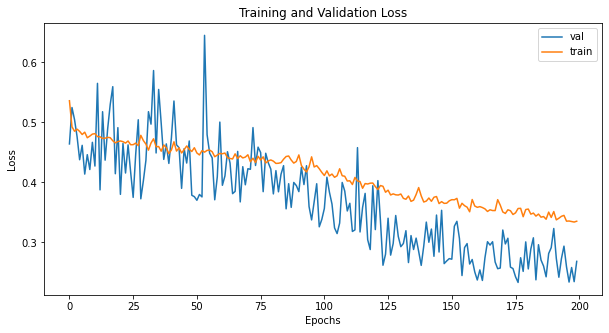

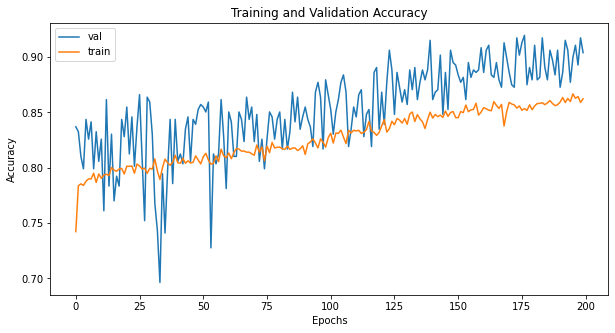

In [23]:
#Checking for overfitting/underfitting
val_loss_list = torch.from_numpy(np.asarray(torch.Tensor(val_loss_list).cpu()))
train_loss_list = torch.from_numpy(np.asarray(torch.Tensor(train_loss_list).cpu()))
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_loss_list,label="val")
plt.plot(train_loss_list,label="train")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

val_accuracy_list = torch.from_numpy(np.asarray(torch.Tensor(val_accuracy_list).cpu()))
train_accuracy_list = torch.from_numpy(np.asarray(torch.Tensor(train_accuracy_list).cpu()))
plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracy")
plt.plot(val_accuracy_list,label="val")
plt.plot(train_accuracy_list,label="train")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [24]:
actual_labels = []
predicted_labels = []

In [25]:
#Test accuracy
model.eval()
with torch.no_grad():
        test_accuracy = []
        
        for data, label in test_loader:
            data = data.to(device)
            label = label.to(device)
            
            actual_labels.extend(np.asarray(label.cpu()).tolist())

            t_output = model(data)
            t_loss = criterion(t_output, label)
            
            predicted_labels.extend(np.asarray(t_output.argmax(dim=1).cpu()).tolist())

            acc = (t_output.argmax(dim=1) == label).float().mean()
            test_accuracy.append(acc)

        final_test_accuracy = sum(test_accuracy)/len(test_accuracy)
        print(f"test_acc : {final_test_accuracy:.4f}\n")

test_acc : 0.8672



In [26]:
print("Actual labels: ")
print(actual_labels)
print("Predicted labels: ")
print(predicted_labels)

Actual labels: 
[1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1,

In [27]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of trainable parameters in the model = {count_parameters(model)}")

Number of trainable parameters in the model = 17585986


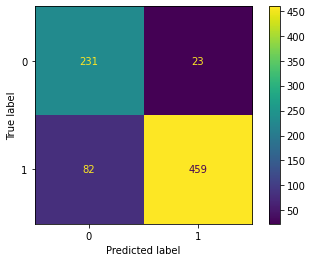

In [28]:
#Confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

cnf_matrix = confusion_matrix(actual_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix)

disp.plot()
plt.show()

In [29]:
#Specificity
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) 
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - cnf_matrix.sum(axis=0) - cnf_matrix.sum(axis=1) + np.diag(cnf_matrix)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

TNR = TN/(TN+FP)

print(f"Class wise specificity:")
print(f"Specificity = {TNR}\n")

print(f"Average specificity:")
print(f"Specificity = {np.average(np.array(TNR))}\n")

Class wise specificity:
Specificity = [0.84842884 0.90944882]

Average specificity:
Specificity = 0.8789388271937357



In [30]:
#Accuracy, Sensitivity, Precision, F1 score
from sklearn.metrics import classification_report

target_names = ['0', '1']
print(classification_report(actual_labels, predicted_labels, target_names=target_names))

              precision    recall  f1-score   support

           0       0.74      0.91      0.81       254
           1       0.95      0.85      0.90       541

    accuracy                           0.87       795
   macro avg       0.85      0.88      0.86       795
weighted avg       0.88      0.87      0.87       795



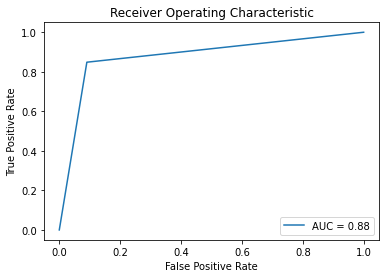

In [31]:
#ROC curve
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(actual_labels, predicted_labels)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [32]:
#AUC
print(f"AUC = {roc_auc}")

AUC = 0.8789388271937355
